In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import re

In [256]:
datas = ['bundesliga','epl','laliga','ligue1','seriea']

df = pd.DataFrame({})
for data in datas:
    temp = pd.read_csv(f"..//data//players_{data}.csv")
    temp['league'] = data
    df = pd.concat([df,temp])

df.head(5)

,age,agent,birth_date,career_stats_career_appearances,career_stats_career_assists,career_stats_career_goals,career_stats_career_minutes,citizenship,club,height,...,name,national_caps,national_goals,position,profile_url,season_stats_appearances,season_stats_assists,season_stats_goals,season_stats_minutes,league
0,36,NaN,"Aug 3, 1988",451.0,27.0,NaN,40481.0,Germany,Bayern Munich,"1,92 m",...,Sven Ulreich,0.0,0.0,Goalkeeper,https://www.transfermarkt.com/sven-ulreich/pro...,2,NaN,NaN,135',bundesliga
1,26,NaN,"Oct 27, 1998",345.0,14.0,10.0,27718.0,France,Bayern Munich,"1,86 m",...,Dayot Upamecano,30.0,2.0,Centre-Back,https://www.transfermarkt.com/dayot-upamecano/...,35,1,2,"2,980'",bundesliga
2,28,NaN,"Nov 15, 1996",300.0,5.0,10.0,25285.0,South,Bayern Munich,"1,90 m",...,Min-jae Kim,69.0,4.0,Centre-Back,https://www.transfermarkt.com/min-jae-kim/prof...,43,-,3,"3,593'",bundesliga
3,29,NaN,"Feb 11, 1996",513.0,17.0,22.0,43825.0,Germany,Bayern Munich,"1,95 m",...,Jonathan Tah,37.0,0.0,Centre-Back,https://www.transfermarkt.com/jonathan-tah/pro...,51,2,4,"4,579'",bundesliga
4,24,NaN,"Jul 10, 2000",142.0,5.0,2.0,12747.0,Israel,Bayern Munich,"1,90 m",...,Daniel Peretz,7.0,0.0,Goalkeeper,https://www.transfermarkt.com/daniel-peretz/pr...,6,NaN,NaN,521',bundesliga


In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2630 entries, 0 to 575
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              2630 non-null   int64  
 1   agent                            1338 non-null   object 
 2   birth_date                       2630 non-null   object 
 3   career_stats_career_appearances  2602 non-null   float64
 4   career_stats_career_assists      2534 non-null   float64
 5   career_stats_career_goals        2270 non-null   float64
 6   career_stats_career_minutes      2602 non-null   float64
 7   citizenship                      2630 non-null   object 
 8   club                             2630 non-null   object 
 9   height                           2608 non-null   object 
 10  market_value                     2613 non-null   object 
 11  name                             2630 non-null   object 
 12  national_caps             

In [258]:
df['agent'] = df['agent'].fillna("No Agent")
df['birth_date'] = pd.to_datetime(df['birth_date'])

In [259]:
df['height']

0      1,92 m
1      1,86 m
2      1,90 m
3      1,95 m
4      1,90 m
        ...  
571    1,90 m
572    1,88 m
573    1,85 m
574    1,93 m
575    1,75 m
Name: height, Length: 2630, dtype: object

In [260]:
df['height'].describe()

count       2608
unique        43
top       1,85 m
freq         188
Name: height, dtype: object

In [261]:
def clean(data):
    data = str(data)
    if data is None:
        return
    data = data.replace(',','')
    data = data.replace('m','')
    return float(data)
df['height'] = df['height'].apply(clean)
df['height'] = df['height'].fillna(df['height'].median())
df['height'] = pd.to_numeric(df['height'],errors='coerce')
df['height'] = df['height'].astype('int32')

In [262]:
df = df.dropna(subset=['market_value'])
def parse_market_value(s):
    if pd.isna(s):
        return None
    pattern = r'€(\d+\.?\d*)([kmb]?)'
    match = re.search(pattern, s.lower())
    if not match:
        return None
    number = float(match.group(1))
    unit = match.group(2)

    if unit == 'k':
        return number * 1_000
    elif unit == 'm':
        return number * 1_000_000
    elif unit == 'b':
        return number * 1_000_000_000
    else:
        return number
df['market_value'] = df['market_value'].apply(parse_market_value)
df['market_value']

0        500000.0
1      50000000.0
2      40000000.0
3      30000000.0
4       3000000.0
          ...    
571    12000000.0
572     2000000.0
573     2500000.0
574     1300000.0
575     4000000.0
Name: market_value, Length: 2613, dtype: float64

In [263]:
columns_fill0 = ['career_stats_career_appearances','career_stats_career_assists','career_stats_career_goals','career_stats_career_minutes','national_caps','national_goals','season_stats_appearances','season_stats_assists','season_stats_goals','season_stats_minutes']

def clean(data):
    data = str(data)
    if data is None:
        return
    data = data.replace(',','')
    data = data.replace('-','')
    data = data.replace('m','')
    data = data.replace('\'','')
    if data == '':
        return np.nan
    try:
        return float(data)
    except ValueError:
        return np.nan
df[columns_fill0] = df[columns_fill0].map(clean)
df[columns_fill0] = df[columns_fill0].fillna(0)
df[columns_fill0].head(5)

,career_stats_career_appearances,career_stats_career_assists,career_stats_career_goals,career_stats_career_minutes,national_caps,national_goals,season_stats_appearances,season_stats_assists,season_stats_goals,season_stats_minutes
0,451.0,27.0,0.0,40481.0,0.0,0.0,2.0,0.0,0.0,135.0
1,345.0,14.0,10.0,27718.0,30.0,2.0,35.0,1.0,2.0,2980.0
2,300.0,5.0,10.0,25285.0,69.0,4.0,43.0,0.0,3.0,3593.0
3,513.0,17.0,22.0,43825.0,37.0,0.0,51.0,2.0,4.0,4579.0
4,142.0,5.0,2.0,12747.0,7.0,0.0,6.0,0.0,0.0,521.0


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2613 entries, 0 to 575
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   age                              2613 non-null   int64         
 1   agent                            2613 non-null   object        
 2   birth_date                       2613 non-null   datetime64[ns]
 3   career_stats_career_appearances  2613 non-null   float64       
 4   career_stats_career_assists      2613 non-null   float64       
 5   career_stats_career_goals        2613 non-null   float64       
 6   career_stats_career_minutes      2613 non-null   float64       
 7   citizenship                      2613 non-null   object        
 8   club                             2613 non-null   object        
 9   height                           2613 non-null   int32         
 10  market_value                     2613 non-null   float64       
 1

In [265]:
df.describe()

,age,birth_date,career_stats_career_appearances,career_stats_career_assists,career_stats_career_goals,career_stats_career_minutes,height,market_value,national_caps,national_goals,season_stats_appearances,season_stats_assists,season_stats_goals,season_stats_minutes
count,2613.000000,2613,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2.613000e+03,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000
mean,26.151933,1998-11-05 23:04:53.455798016,250.908534,21.748948,29.809032,18129.911213,183.615767,1.157429e+07,13.657482,1.719097,24.096441,1.823574,2.398393,1566.537696
min,16.000000,1982-08-31 00:00:00,0.000000,0.000000,0.000000,0.000000,163.000000,5.000000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,1995-09-06 00:00:00,136.000000,6.000000,5.000000,8883.000000,179.000000,1.500000e+06,0.000000,0.000000,12.000000,0.000000,0.000000,510.000000
50%,26.000000,1999-03-07 00:00:00,231.000000,15.000000,16.000000,16224.000000,184.000000,5.000000e+06,4.000000,0.000000,27.000000,1.000000,1.000000,1478.000000
75%,29.000000,2002-05-06 00:00:00,343.000000,29.000000,38.000000,24959.000000,188.000000,1.500000e+07,17.000000,1.000000,36.000000,3.000000,3.000000,2467.000000
max,42.000000,2008-08-30 00:00:00,952.000000,281.000000,610.000000,85656.000000,206.000000,2.000000e+08,188.000000,85.000000,60.000000,25.000000,43.000000,5122.000000
std,4.587698,NaN,146.974729,23.476971,41.111406,11720.631504,6.777989,1.806006e+07,21.879389,5.188404,15.131022,2.771800,4.203945,1174.586451


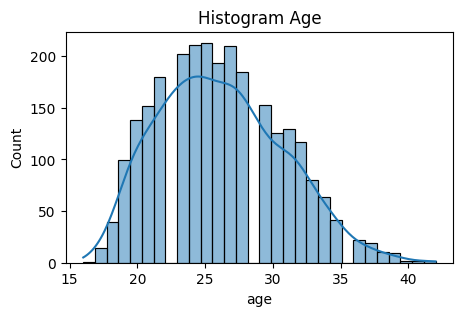

In [266]:
plt.figure(figsize=(5,3))
sns.histplot(df['age'],kde=True)
plt.title('Histogram Age')
plt.show()

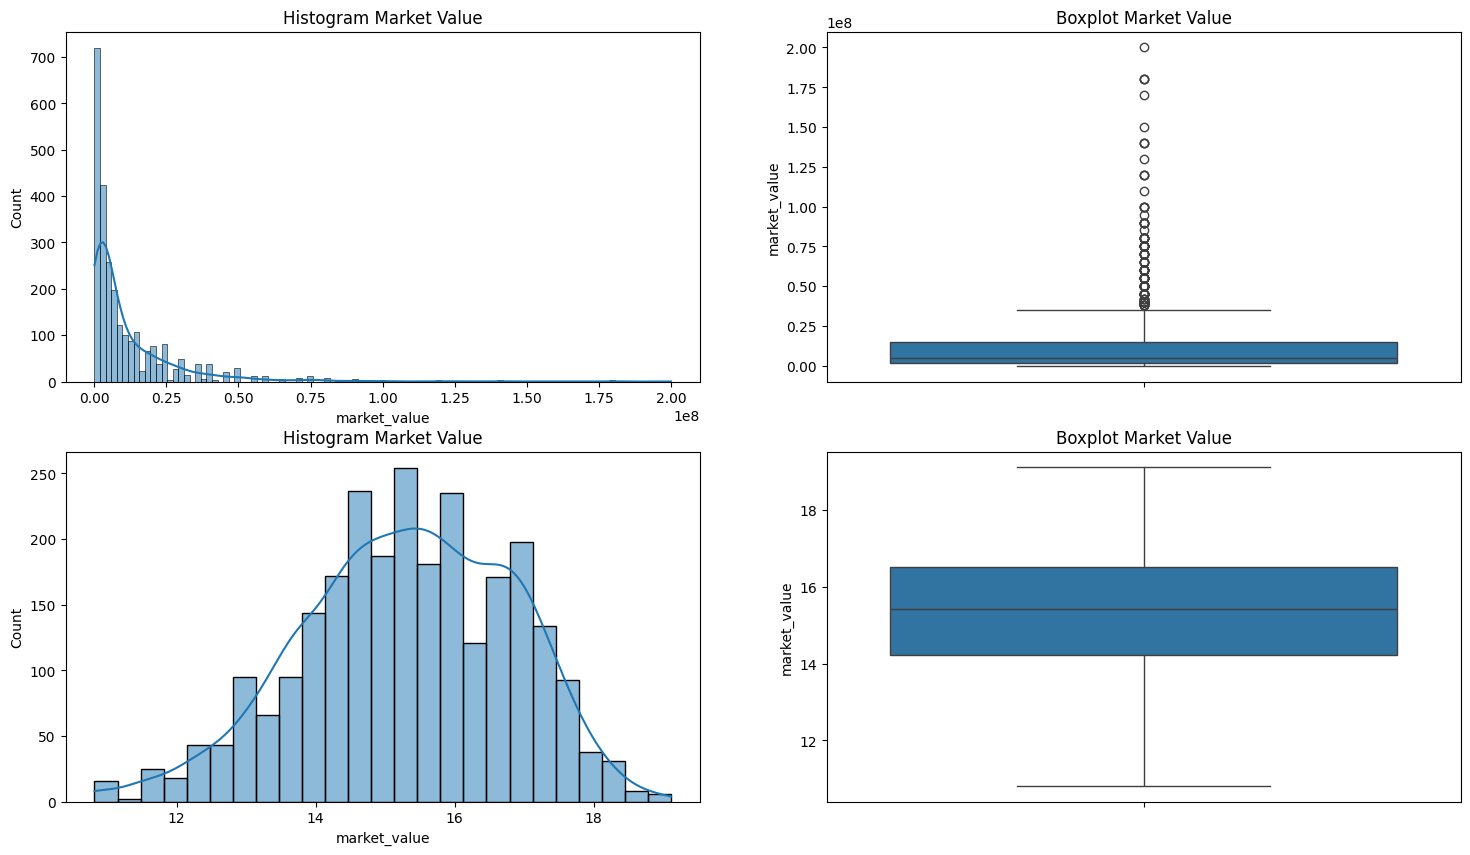

In [267]:
fig,axes = plt.subplots(2,2,figsize=(18,10))
sns.histplot(df['market_value'],kde=True,ax=axes[0,0])
axes[0,0].set_title("Histogram Market Value")
sns.boxplot(df['market_value'],ax=axes[0,1])
axes[0,1].set_title("Boxplot Market Value")

sns.histplot(np.log1p(df['market_value']),kde=True,ax=axes[1,0])
axes[1,0].set_title("Histogram Market Value")
sns.boxplot(np.log1p(df['market_value']),ax=axes[1,1])
axes[1,1].set_title("Boxplot Market Value")
plt.show()

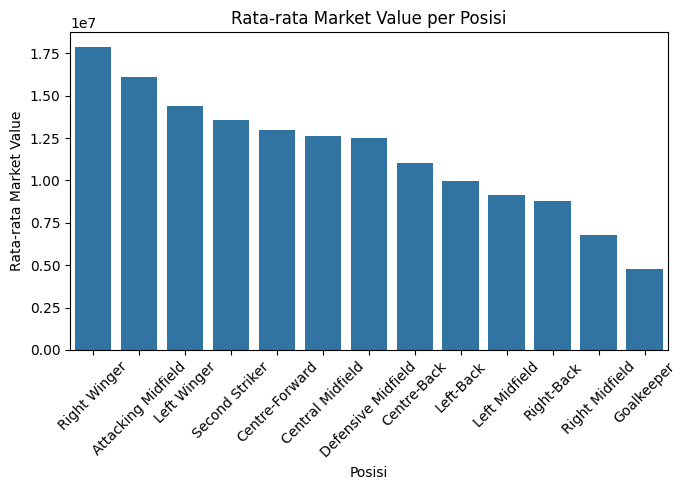

In [268]:
position_mean = df.groupby('position')['market_value'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=position_mean, x='position', y='market_value', order=position_mean['position'])

plt.title('Rata-rata Market Value per Posisi')
plt.xlabel('Posisi')
plt.ylabel('Rata-rata Market Value')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

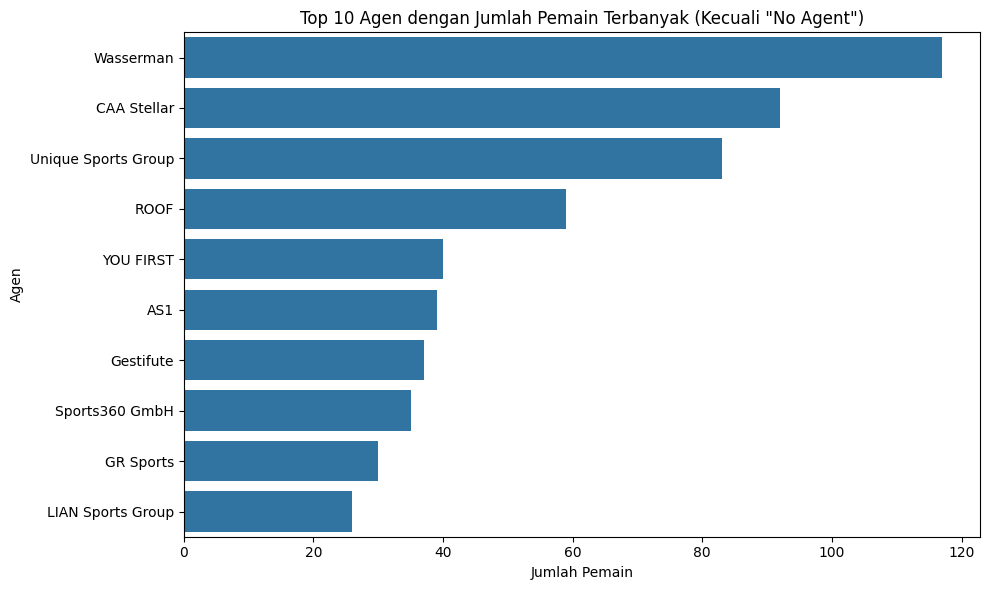

In [285]:
df_filtered = df[df['agent'] != 'No Agent']

top_10_agents = df_filtered['agent'].value_counts().head(10).index

df_top_agents = df_filtered[df_filtered['agent'].isin(top_10_agents)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_top_agents, y='agent', order=top_10_agents)

plt.title('Top 10 Agen dengan Jumlah Pemain Terbanyak (Kecuali "No Agent")')
plt.xlabel('Jumlah Pemain')
plt.ylabel('Agen')
plt.tight_layout()
plt.show()

In [269]:
df['season_ga'] = df['season_stats_goals'] + df['season_stats_assists']

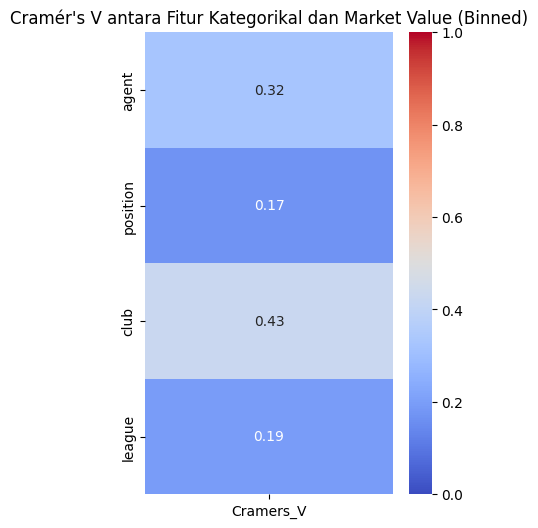

In [270]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

df['market_value_bin'] = pd.qcut(df['market_value'], q=4, labels=False)

features_categorical = ['agent', 'position', 'club', 'league']

cramers_results = {}
for feature in features_categorical:
    cramers_results[feature] = cramers_v(df[feature], df['market_value_bin'])

cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=['Cramers_V'])

plt.figure(figsize=(4, 6))
sns.heatmap(cramers_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)

plt.title("Cramér's V antara Fitur Kategorikal dan Market Value (Binned)")
plt.show()

<Figure size 500x300 with 0 Axes>

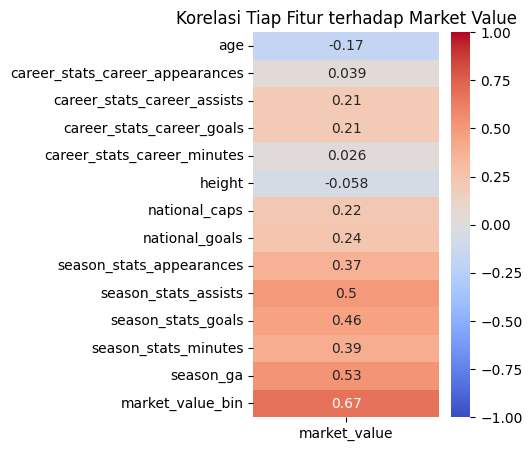

In [271]:
plt.figure(figsize=(5,3))
corr = df.corr(numeric_only=True)
corr_market_value = corr[['market_value']].drop('market_value')

plt.figure(figsize=(3, 5))
sns.heatmap(corr_market_value, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title("Korelasi Tiap Fitur terhadap Market Value")
plt.show()

In [272]:
df = df.drop(['career_stats_career_appearances','career_stats_career_minutes','height','birth_date','name','profile_url'],axis=1)
df.head(5)

,age,agent,career_stats_career_assists,career_stats_career_goals,citizenship,club,market_value,national_caps,national_goals,position,season_stats_appearances,season_stats_assists,season_stats_goals,season_stats_minutes,league,season_ga,market_value_bin
0,36,No Agent,27.0,0.0,Germany,Bayern Munich,500000.0,0.0,0.0,Goalkeeper,2.0,0.0,0.0,135.0,bundesliga,0.0,0
1,26,No Agent,14.0,10.0,France,Bayern Munich,50000000.0,30.0,2.0,Centre-Back,35.0,1.0,2.0,2980.0,bundesliga,3.0,3
2,28,No Agent,5.0,10.0,South,Bayern Munich,40000000.0,69.0,4.0,Centre-Back,43.0,0.0,3.0,3593.0,bundesliga,3.0,3
3,29,No Agent,17.0,22.0,Germany,Bayern Munich,30000000.0,37.0,0.0,Centre-Back,51.0,2.0,4.0,4579.0,bundesliga,6.0,3
4,24,No Agent,5.0,2.0,Israel,Bayern Munich,3000000.0,7.0,0.0,Goalkeeper,6.0,0.0,0.0,521.0,bundesliga,0.0,1


In [275]:
df.to_csv("..//data//clean.csv",index=False)

Insight:

    - Distribusi age cukup normal
    - Market value sangat right-skewed, perlu transform dengan log-transform
    - Posisi right-winger memiliki market value rata rata tertinggi dibanding posisi lain
    - Kolom career_appearances, height, career_minutes dihapus karena kurang relevan dengan target market_value
    - Kolom birth_date, name, profile_url dihapus karena tidak digunakan dalam pembuatan model